In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import dice_coef, ss_metric, compute_metric
import nibabel as nib
from sklearn.model_selection import KFold
%matplotlib inline

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
max_epochs = 30
BATCH_SIZE = 8
lr = 0.001
opt = tf.keras.optimizers.Adam(lr)
ver = 'self_attention_02' #save version 
dropout=0.3 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/'
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack03/"

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

def data_aug(imgs, seed=8888):
    x = tf.image.random_flip_up_down(imgs,seed)
    x = tf.image.random_flip_left_right(x,seed)
    return x

---

# Layer Names

In [4]:
# template for guided attention block
layer_name_p01 = ['pam01_conv01', 'pam01_conv02', 'pam01_softmax', 'pam01_conv03',
                  'pam01_alpha','pam01_add']
layer_name_c01 = ['cam01_softmax', 'cam01_alpha','cam01_add']
layer_name_p02 = ['pam02_conv01', 'pam02_conv02', 'pam02_softmax', 'pam02_conv03',
                  'pam02_alpha', 'pam02_add']
layer_name_c02 = ['cam02_softmax', 'cam02_alpha','cam02_add']
layer_name_template = [layer_name_p01, layer_name_c01, layer_name_p02, layer_name_c02]

layer_name_ga = []
for b in range(1,4):
    layer_block = []
    for layer in layer_name_template:
        layer_internal = [i+'block0{}'.format(b) for i in layer]
        layer_block.append(layer_internal)
    layer_name_ga.append(layer_block)

----

# Model

In [5]:
from utils_model import conv_block, coordconv_block, up, pool, attention_block
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply, GaussianNoise
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, Dropout, Softmax, concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Layer, Softmax
from coord_conv import CoordConv

def conv_block_sep(x_in, filters, layer_name, batch_norm=False, kernel_size=(3, 3),
               kernel_initializer='glorot_uniform', acti='relu', dropout_rate=None):
    assert type(filters)==list, "Please input filters of type list."
    assert type(layer_name)==list, "Please input filters of type list."
    x = SeparableConv2D(filters[0], kernel_size, padding='same', kernel_initializer=kernel_initializer, name = layer_name[0])(x_in)
    if batch_norm == True:
        x = BatchNormalization()(x)
    x = Activation(acti)(x)
    x = SeparableConv2D(filters[1], kernel_size, padding='same', kernel_initializer=kernel_initializer, name = layer_name[1])(x)
    if batch_norm == True:
        x = BatchNormalization()(x)
    x = Activation(acti)(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    return x

def conv_2d_sep(x_in, filters, layer_name, batch_norm=False, kernel_size=(3, 3), acti='relu',
            kernel_initializer='glorot_uniform', dropout_rate=None):
    x = SeparableConv2D(filters, kernel_size, padding='same', kernel_initializer=kernel_initializer, name=layer_name)(x_in)
    if batch_norm == True:
        x = BatchNormalization()(x)
    x = Activation(acti)(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    return x

def conv_2d(x_in, filters, layer_name, strides=(1,1), batch_norm=False, kernel_size=(3, 3), acti='relu',
            kernel_initializer='glorot_uniform', dropout_rate=None):
    x = Conv2D(filters, kernel_size, strides, padding='same', kernel_initializer=kernel_initializer, name=layer_name)(x_in)
    if batch_norm == True:
        x = BatchNormalization()(x)
    x = Activation(acti)(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    return x

def down_sampling_sep(x_in, filters, layer_name, batch_norm=False, kernel_size=(3, 3), acti='relu',
            kernel_initializer='glorot_uniform', dropout_rate=None, mode ='coord', x_dim=None, y_dim=None):
    assert mode=='coord' or mode=='normal', "Use 'coord' or 'normal' for mode!"
    if mode=='coord':
        #seperable coordconv
        assert (x_dim!=None and y_dim!=None), "Please input dimension for CoordConv!"
        x = Conv2D(1, kernel_size, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x_in)
        x = CoordConv(x_dim=x_dim, y_dim=y_dim, with_r=False, filters=filters, strides=(1,1), 
                      kernel_size = 3, padding='same', kernel_initializer=kernel_initializer, name=layer_name)(x)
    else:
        #normal mode
        x = SeparableConv2D(filters, kernel_size, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer, name=layer_name)(x_in)
    if batch_norm == True:
        x = BatchNormalization()(x)
    x = Activation(acti)(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    return x

def res_block_sep(x_in, filters,  layer_name, batch_norm=False, kernel_size=(3, 3),
               kernel_initializer='glorot_uniform', acti='relu', dropout_rate=None):
    assert len(filters)==2, "Please assure that there is 3 values for filters."
    assert len(layer_name)==3, "Please assure that there is 3 values for layer name"
    layer_name_conv = [layer_name[i] for i in range(len(layer_name)-1)]
    output_conv_block = conv_block_sep(x_in, filters, layer_name_conv, batch_norm=batch_norm, kernel_size=kernel_size,
                                   kernel_initializer = kernel_initializer, acti = acti, dropout_rate=dropout_rate)
    output_add = Add(name = layer_name[-1])([output_conv_block, x_in])
    return output_add

def attention_block(input_signal, gated_signal, filters, att_layer_name):
    #input signal feature maps
    is_fm = Conv2D(filters, kernel_size=(1,1), strides=(2, 2), padding = 'same')(input_signal)
    #gated signal feature maps
    gs_fm = Conv2D(filters, kernel_size=(1,1), strides=(1, 1), padding = 'same')(gated_signal)
    #debugger
    assert is_fm.shape!=gs_fm.shape, "Feature maps shape doesn't match!"
    #element wise sum
    add = Add()([is_fm, gs_fm])
    acti = Activation('relu')(add)
    #downsampled attention coefficient
    bottle_neck = Conv2D(1, kernel_size=(1,1), activation='sigmoid', name=att_layer_name)(acti)
    #bilinear interpolation to get attention coeffcient
    alpha = UpSampling2D(interpolation='bilinear')(bottle_neck)
    #filter off input signal's features with attention coefficient
    multi = Multiply()([input_signal, alpha])
    return multi

def PAM(inp_feature, layer_name, kernel_initializer='glorot_uniform', acti='relu'):
    '''
    Position attention module
    by default input shape => [w,h,c],[240, 240, 128] hence c/8 = 16
    :param layer_name: List of layer names
    [1st conv block, 2nd conv block, softmax output, 3rd conv block, position coefficient, Add output]
    :param inp_feature: feature maps of res block after up sampling [w,h,c]
    :return: PAM features [w/4,h/4,c]
    '''
    #downsampling by scale of 4 for GPU memory issue
    inp_feature = Conv2D(filters=128,kernel_size=1, strides=2, padding='same',activation='relu')(inp_feature) 
    inp_feature = Conv2D(filters=128,kernel_size=1, strides=2, padding='same',activation='relu')(inp_feature) 
    #dimensions
    b,w,h,c = inp_feature.shape
    #scale down ratio
    c_8 = c//8
    #
    assert len(layer_name)>=5, 'Layer list length should be 5!'
    # Branch01 Dimension: [w,h,c/8] => [(wxh),c/8]
    query = conv_2d(inp_feature, filters=c_8, layer_name=layer_name[0], batch_norm=False, kernel_size=(1, 1), acti=acti,
            kernel_initializer=kernel_initializer, dropout_rate=None)
    query = tf.reshape(query,[-1,(w*h),c_8 ])
    # Branch02 Dimension: [w,h,c/8] => [c/8,(wxh)]
    key = conv_2d(inp_feature, filters=c_8, layer_name=layer_name[1], batch_norm=False, kernel_size=(1, 1), acti=acti,
        kernel_initializer=kernel_initializer, dropout_rate=None)
    key = tf.reshape(key, [-1,(w*h),c_8 ])
    key = tf.einsum('bij->bji', key) #transpose/permutation
    #matmul pipeline 01 & 02
    matmul_0102 = tf.einsum('bij,bjk->bik', query, key) #[(wxh),(wxh)]
    softmax0102 = Softmax(name=layer_name[2])(matmul_0102)
    # Branch03
    value = conv_2d(inp_feature, filters=c, layer_name=layer_name[3], batch_norm=False, kernel_size=(1, 1), acti=acti,
        kernel_initializer=kernel_initializer, dropout_rate=None)
    value = tf.reshape(value,[-1,(w*h),c]) #[(wxh),c]
    matmul_all = tf.einsum('bij,bjk->bik',softmax0102,value) #[(wxh),c]
    # Output
    output = tf.reshape(matmul_all, [-1,w,h,c]) #[w,h,c]
    #learnable coefficient to control the importance of CAM
    lambda_p = Conv2D(filters=1,kernel_size=1, padding='same',activation='sigmoid', name=layer_name[4])(inp_feature)
    output = Multiply()([output, lambda_p])
    output_add = Add(name = layer_name[-1])([output, inp_feature])
    return output_add

def CAM(inp_feature, layer_name):
    '''
    Channel attention module 
    by default input shape => [w,h,c],[240, 240, 128] hence c/8 = 16
    :param inp_feature: feature maps of res block after up sampling [w,h,c]k
    :param layer_name: List of layer names
        [softmax output, channel attention coefficients, Add output]
    :return: CAM features [w/2,h/2,c] 
    '''
    #downsampling by scale of 4 for GPU memory issue 
    inp_feature = Conv2D(filters=128,kernel_size=1, strides=2, padding='same',activation='relu')(inp_feature)
    inp_feature = Conv2D(filters=128,kernel_size=1, strides=2, padding='same',activation='relu')(inp_feature)
    #dimensions
    b,w,h,c = inp_feature.shape
    #learnable coefficient to control the importance of CAM
    assert len(layer_name)>=2, 'Layer list length should be 2!'
    # Branch01 Dimension: [w,h,c] => [(wxh),c]
    query = tf.reshape(inp_feature, [-1,(w*h),c])
    # Branch02 Dimension: [w,h,c] => [c,(wxh)]
    key = tf.reshape(inp_feature, [-1,(w*h),c]) #[(wxh),c]
    key = tf.einsum('ijk->ikj', key) #Permute:[c,(wxh)]
    #matmul pipeline 01 & 02
    matmul_0201 = tf.einsum('ijk,ikl->ijl', key, query) #[c,c]
    softmax0102 = Softmax(name=layer_name[0])(matmul_0201)
    # Branch03 Dimension: [w,h,c] => [c,(wxh)]
    value = tf.reshape(inp_feature,[-1,(w*h),c]) #[(wxh),c]
    matmul_all = tf.einsum('ijk,ikl->ijl', value,softmax0102) #[(wxh),c]
    #output
    output = tf.reshape(matmul_all,[-1,w,h,c])#[w,h,c]
    #provides learnable parameter
    #*channel wise attention, inspired by Squeeze Excitation(SE) block
    GAP = GlobalAveragePooling2D()(output)
    dense01 = Dense(c//8, activation='relu')(GAP)
    alpha_c = Dense(c,activation='sigmoid', name=layer_name[1])(dense01)
    #outputs
    output = Multiply()([output, alpha_c])
    output_add = Add(name=layer_name[-1])([output, inp_feature])
    return output_add

def guided_attention_block(inp_feature, layer_name_p, layer_name_c):
    '''
    Guided attention block that takes feature as input and concatenates features
    from PAM and CAM as output
    :param inp_feature: Input features
    :param layer_name_p: layer name list for PAM
    :param layer_name_c: layer name list for CAM
    :return: squeezed concatenated features of PAM and CAM
    '''
    pam_feature = PAM(inp_feature, layer_name_p, kernel_initializer=hn)
    cam_feature = CAM(inp_feature, layer_name_c)
    add = Add()([pam_feature,cam_feature]) #[60,60,128]
    up = UpSampling2D(size=(4,4))(add) #[240,240,128]
    squeeze = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn,
                       activation='relu')(up)
    return squeeze

def guided_attention(res_feature, ms_feature, layer_name):
    '''
    Guided attention module
    :param res_feature: Upsampled Feature maps from Res Block
    :param ms_feature: Multi scale feature maps result from Res Block
    :param layer_name: Layer Name should consist be a list contating 4 list
    Example:
    layer_name_p01 = ['pam01_conv01', 'pam01_conv02', 'pam01_softmax', 'pam01_conv03',
                      'pam01_alpha','pam01_add']
    layer_name_c01 = ['cam01_softmax', 'cam01_alpha','cam01_add']
    layer_name_p02 = ['pam02_conv01', 'pam02_conv02', 'pam02_softmax', 'pam02_conv03',
                      'pam02_alpha', 'pam02_add']
    layer_name_c02 = ['cam02_softmax', 'cam02_alpha','cam02_add']
    layer_name = [layer_name_p01, layer_name_c01, layer_name_p02, layer_name_c02]

    :return: guided attention module with shape same as input
    '''
    assert len(layer_name)==4, "Layer name should be a list consisting 4 lists!"
    #self attention block01
    concat01 = concatenate([res_feature, ms_feature], axis=-1)
    squeeze01 = guided_attention_block(concat01, layer_name[0], layer_name[1])
    multi01 = Multiply()([squeeze01, ms_feature])
    #self attention block02
#     concat02 = concatenate([multi01, res_feature],axis=-1)
#     squeeze02 = guided_attention_block(concat02, layer_name[2], layer_name[3])
    return multi01

def forward(x):
    '''
    Resnet as backbone for multiscale feature retrieval.
    Each resblock output(input signal), next resblock output(gated signal) is
    feed into the gated attention for multi scale feature refinement.
    Each gated attention output is pass through a bottle neck layer to standardize
    the channel size by squashing them to desired filter size of 64.
    The features are upsampled at each block to the corresponding [wxh] dimension
    of w:240, h:240.
    The upsampled features are concat and squash to corresponding channel size of 64
    which yield multiscale feature.
    :param x: batched images
    :return: feature maps of each res block
    '''
    #inject noise
    gauss1 = GaussianNoise(0.01)(x)
    #---- ResNet and Multiscale Features----
    #1st block
    conv01 = CoordConv(x_dim=240, y_dim=240, with_r=False, filters=64, strides=(1,1),
                      kernel_size = 3, padding='same', kernel_initializer=hn, name='conv01')(gauss1)
    res_block01 = res_block_sep(conv01, filters=[128, 64], layer_name=["conv02", "conv03", "add01"])
    #2nd block
    down_01 = down_sampling_sep(res_block01, filters=128, layer_name = 'down_01',  kernel_initializer=hn,
                               mode='normal',x_dim=120, y_dim=120)
    res_block02 = res_block_sep(down_01, filters=[256, 128], layer_name=["conv04", "conv05", "add02"])
    #3rd block
    down_02 = down_sampling_sep(res_block02, filters=256, layer_name = 'down_02',  kernel_initializer=hn,
                               mode='normal',x_dim=60, y_dim=60)
    res_block03 = res_block_sep(down_02, filters=[512, 256], layer_name=["conv06", "conv07", "add03"])
    #4th block
    down_03 = down_sampling_sep(res_block03, filters=512, layer_name = 'down_03',  kernel_initializer=hn,
                               mode='normal',x_dim=30, y_dim=30)
    res_block04 = res_block_sep(down_03, filters=[1024, 512], layer_name=["conv08", "conv09", "add04"])
    #grid attention blocks
    att_block01 = attention_block(res_block01,res_block02,64,'grid_att01')
    att_block02 = attention_block(res_block02,res_block03,128,'grid_att02')
    att_block03 = attention_block(res_block03, res_block04,256,'gird_att03')
    #bottle neck => layer squash all attention block to same filter size 64
    bottle01 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block01)
    bottle02 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block02)
    bottle03 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block03)
    #upsampling for all layers to same (wxh) dimension=>240x240
    up01 = bottle01 #[240,240,64]
    up02 = UpSampling2D(size=(2, 2), interpolation='bilinear')(bottle02) #[120,120,64]=>[240,240,64]
    up03 = UpSampling2D(size=(4,4), interpolation='bilinear')(bottle03) #[60,60,64]=>[240,240,64]
    #multiscale features
    concat_all = concatenate([up01,up02,up03],axis=-1) #[240,240,3*64]
    #squeeze to have the same channel as upsampled features [240,240,3*64] => [240,240,64]
    ms_feature = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(concat_all)
    #Segmentations from multiscale features *without softmax activation
    seg_01 = Conv2D(4, (1,1), name='seg_01')(up01)
    seg_02 = Conv2D(4, (1,1), name='seg_02')(up02)
    seg_03 = Conv2D(4, (1,1), name='seg_03')(up02)

    #----self guided attention blocks-----
    ga_01 = guided_attention(up01, ms_feature, layer_name_ga[0])
    ga_02 = guided_attention(up02, ms_feature, layer_name_ga[1])
    ga_03 = guided_attention(up03, ms_feature, layer_name_ga[2])
    #Segmentations from guided attention features *without softmax activation
    seg_ga01 = Conv2D(4, (1,1), name='seg_ga01')(ga_01)
    seg_ga02 = Conv2D(4, (1,1), name='seg_ga02')(ga_02)
    seg_ga03 = Conv2D(4, (1,1), name='seg_ga03')(ga_03)
    #outputs for xent losses
    output_xent = [seg_01, seg_02, seg_03, seg_ga01, seg_ga02, seg_ga03]
    #output for dice coefficient loss
    pred_seg = Add()(output_xent)
    output_dice = Softmax()(pred_seg/len(output_xent))
    return output_xent, output_dice

In [6]:
#Build Model
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, forward(input_layer))

In [7]:
xent_logit = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        output_xent, output_dice = model(image, training=True)
        loss_dice = generalized_dice_loss(label, output_dice)
        loss_xents=[]
        for seg in output_xent:
            loss_xent = xent_logit(label, seg)
            loss_xents.append(loss_xent)
        loss_total = sum(loss_xents)+loss_dice
    gradients = tape.gradient(loss_total, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return output_dice, loss_total, gradients

@tf.function
def val_fn(image, label):
    model_output = model(image, training=False)
    loss = custom_loss(label, model_output)
    return model_output, loss

---


Epochs  1



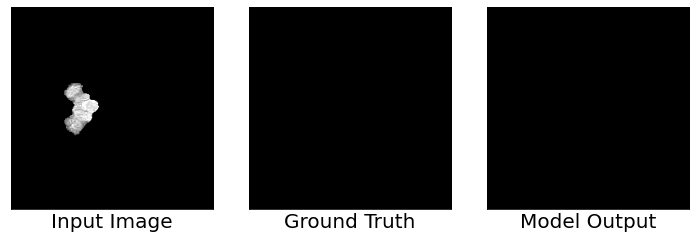

Steps: 5000, Loss:0.3434741199016571
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.07564428448677063, max:0.1873023808002472
Compute time per epochs: 72.70 mins

Epochs  2



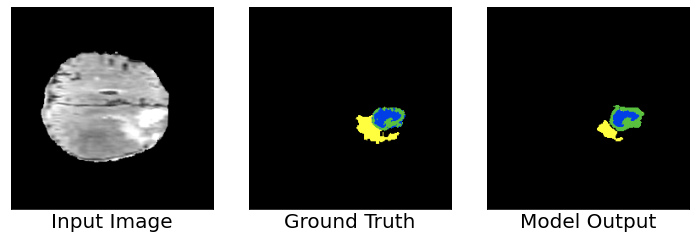

Steps: 5000, Loss:0.2997349202632904
Accurary: 0.9898263812065125
Dice coefficient: [0.95232755, 0.8050314, 0.83866435]
Sensitivity: [0.986062717931908, 0.9896907219151876, 0.7489014453929601]
Specificity: [0.9987134070042275, 0.9968188491930331, 0.9989465602515852]
Gradient min:-0.06337559968233109, max:0.06437058746814728
Compute time per epochs: 72.51 mins

Epochs  3


In [ ]:
epochs = 1
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    start = time.time()
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    ds = os.listdir(tfrecords_read_dir)
    #shuffle directory list of tfrecords
    shuffle = random.shuffle(ds)
    for tf_re in ds:
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            #data augmentation
            imgs = data_aug(imgs)
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32)
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%5000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        #'core','enhancing','complete'
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    elapsed_time =(time.time()-start)/60 #unit in mins
    print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
    epochs+=1

---

# Save Weights

In [ ]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [ ]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def output_fn(image):
    model.trainable = False
    model_output = model(image)
    return model_output

In [ ]:
# ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/'
# save_path = '/home/kevinteng/Desktop/ssd02/submission/'
# actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
# #all brain affine are the same just pick one 
# brain_affine = nib.load(actual_label).affine
# steps = 1
# acc_list = []
# for train_or_val in sorted(os.listdir(ds)):
#     save_dir = save_path + train_or_val+'_'+ver
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
#     merge01 = os.path.join(ds+train_or_val)
#     for patient in sorted(os.listdir(merge01)):
#         patient_id = patient.split('.')[0]
#         merge02 = os.path.join(merge01,patient)
#         imgs = np.load(merge02)
#         image = imgs[:,:,:,:4]
#         seg_output = 0 #flush RAM
#         seg_output = np.zeros((240,240,155))
#         for i in range(image.shape[0]):
#             inp = tf.expand_dims(image[i],0)
#             img_seg = output_fn(inp) #validation function 
#             #map from sparse to label
#             seg_output[:,:,i] = np.argmax(img_seg,-1) 
#         #convert label from 4 to 3 and np array and cast as int
#         seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
#         prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
#         prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

---

# Model Summary

In [ ]:
model.summary()